<a href="https://colab.research.google.com/github/melissa-mariano/projects/blob/main/CAC_40_RSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installation des paquets

In [1]:
!pip install -q Unidecode

In [2]:
!pip install -q pdfplumber requests tqdm

In [3]:
!pip install langdetect -q

In [4]:
!pip install -q spacy
!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 71.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 106.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
from unidecode import unidecode
import numpy as np
import pandas as pd
import io, os, time, requests, pdfplumber
from tqdm import tqdm
import re
import spacy
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 42
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


# importation et préparation des données d’entrée

In [6]:
# ---- entrées ----
PATH_CSV = "/content/données(Feuil1).csv"  # contient les colonnes Nom et Lien
DOC_LVMH = "/content/LVMH_Rapport_Engagement-2024.pdf"
DOC_THALES = "/content/Thales-Rapport-Intégré-RSE-2024-FR_0.pdf"
DOC_SAFRAN = "/content/SAFRAN-Rapport intégré 2024 - FR.pdf"
DOC_EDENRED	= "/content/2024-2025-fr-edenred-rapport-integre.pdf"
DOC_ESSILORLUXOTTICA = "/content/2024_Sustainability-report_EssilorLuxottica.pdf"
DOC_SAINT_GOBAIN = "/content/Saint-Gobain RI 2024 pap FRE lite.pdf"
DOC_SCHNEIDER = "/content/Rapport-integre-2024_tcm342-511188.pdf"
DOC_STMICROELECTRONICS = "/content/STM_AR_Master - DAR 2024 (Investor relations).pdf"
DOC_VINCI = "/content/VINCI - Aim for an all-around performance_0.pdf"
DOC_EURONEXT = "/content/Euronext Sustainability Statement - 2024.pdf"
DOC_BOUYGUES = "/content/ri_bouygues_2025_web.pdf"


# Lecture du fichier CSV (seulement les colonnes nécessaires)
base = pd.read_csv(PATH_CSV, sep=";", encoding="latin1")[["Nom", "Lien"]]

# Nettoyage des espaces et des valeurs manquantes
base["Nom"] = base["Nom"].astype(str).str.strip()
base["Lien"] = base["Lien"].astype(str).str.strip()

# Remplacement des liens manquants par les documents locaux
# Si le fichier CSV contient déjà un lien, celui-ci est remplacé par le document local
base.loc[base["Nom"].str.upper().str.contains("LVMH"), "Lien"] = DOC_LVMH
base.loc[base["Nom"].str.upper().str.contains("THALES"), "Lien"] = DOC_THALES
base.loc[base["Nom"].str.upper().str.contains("SAFRAN"), "Lien"] = DOC_SAFRAN
base.loc[base["Nom"].str.upper().str.contains("EDENRED"), "Lien"] = DOC_EDENRED
base.loc[base["Nom"].str.upper().str.contains("ESSILORLUXOTTICA"), "Lien"] = DOC_ESSILORLUXOTTICA
base.loc[base["Nom"].str.upper().str.contains("GOBAIN"), "Lien"] = DOC_SAINT_GOBAIN
base.loc[base["Nom"].str.upper().str.contains("SCHNEIDER"), "Lien"] = DOC_SCHNEIDER
base.loc[base["Nom"].str.upper().str.contains("STMICROELECTRONICS"), "Lien"] = DOC_STMICROELECTRONICS
base.loc[base["Nom"].str.upper().str.contains("VINCI"), "Lien"] = DOC_VINCI
base.loc[base["Nom"].str.upper().str.contains("EURONEXT"), "Lien"] = DOC_EURONEXT
base.loc[base["Nom"].str.upper().str.contains("BOUYGUES"), "Lien"] = DOC_BOUYGUES

# Renommage des colonnes pour obtenir le format final : Nom + Document
base = base.rename(columns={"Lien": "Document"})[["Nom", "Document"]]

# Création d’un dictionnaire Nom → Document
base_dict = dict(zip(base["Nom"], base["Document"]))

print(f"Nombre total d’entreprises: {len(base)}")
print("Exemples du dictionnaire:", list(base_dict.items())[:5])

Nombre total d’entreprises: 40
Exemples du dictionnaire: [('ACCOR', 'https://assets.group.accor.com/yrj0orc8tx24/4tViUa177mMSGQxNgi0SWS/8cf8a1fb36f19b9f7cbfc2aae4beb939/ACCOR_RI_2024_MEL_FR.pdf'), ('AIR LIQUIDE', 'https://fr.airliquide.com/statics/2025-07/Rapport%20RSE%20ALFI%202024.pdf'), ('AIRBUS', 'https://www.airbus.com/sites/g/files/jlcbta136/files/2025-04/Airbus%20Annual%20Report%202024.pdf'), ('ARCELORMITTAL SA', 'https://france.arcelormittal.com/IMG/pdf/rapport_rse_2023_-_edition_2024_-_v9_copie.pdf'), ('AXA', 'https://www-axa-com.cdn.prismic.io/www-axa-com/aN0S-p5xUNkB1WqD_axa_ri2024_accessible_vf.pdf')]


Outil de recherche d’URL par entreprise

In [7]:
def _norm(s: str) -> str:
    return unidecode(str(s)).strip().lower()

# dictionnaire normalisé → Document (construit à partir de base_dict)
_norm_map = {_norm(n): doc for n, doc in base_dict.items()}

def buscar_documento(nome: str):
    """Tapez 'ACCOR' (ou 'accor') pour obtenir l’URL/le fichier ; renvoie NaN si introuvable."""
    q = _norm(nome)
    if q in _norm_map:
        return _norm_map[q]
    # recherche secondaire : si aucun résultat exact, on tente une correspondance partielle
    hits = base[base["Nom"].map(_norm).str.contains(q, na=False)]
    return hits["Document"].iloc[0] if not hits.empty else np.nan

# exemplos:
print(buscar_documento("SAFRAN"))
print(buscar_documento("accor"))
print(buscar_documento("Thales"))
print(buscar_documento("EURONEXT"))


/content/SAFRAN-Rapport intégré 2024 - FR.pdf
https://assets.group.accor.com/yrj0orc8tx24/4tViUa177mMSGQxNgi0SWS/8cf8a1fb36f19b9f7cbfc2aae4beb939/ACCOR_RI_2024_MEL_FR.pdf
/content/Thales-Rapport-Intégré-RSE-2024-FR_0.pdf
/content/Euronext Sustainability Statement - 2024.pdf




---



Définition de DOCS comme table officielle des données

In [8]:
# définir officiellement
DOCS = base.copy()  # base principale : Nom, Document

# vérifications utiles
print("Linhas totais:", len(DOCS))
print("Sem documento (NaN):", DOCS["Document"].isna().sum())

# doublons
dup_nom = DOCS["Nom"].duplicated(keep=False).sum()
dup_doc = DOCS["Document"].duplicated(keep=False).sum()
print("Nomes duplicados:", dup_nom, "| Documentos duplicados:", dup_doc)

# afficher les cas problématiques (le cas échéant)
if DOCS["Document"].isna().any():
    display(DOCS[DOCS["Document"].isna()].head())

Linhas totais: 40
Sem documento (NaN): 0
Nomes duplicados: 0 | Documentos duplicados: 0


In [9]:
DOCS.head(40)

,Nom,Document
0,ACCOR,https://assets.group.accor.com/yrj0orc8tx24/4t...
1,AIR LIQUIDE,https://fr.airliquide.com/statics/2025-07/Rapp...
2,AIRBUS,https://www.airbus.com/sites/g/files/jlcbta136...
3,ARCELORMITTAL SA,https://france.arcelormittal.com/IMG/pdf/rappo...
4,AXA,https://www-axa-com.cdn.prismic.io/www-axa-com...
5,BNP PARIBAS ACT.A,https://invest.bnpparibas/document/rapport-int...
6,BOUYGUES,/content/ri_bouygues_2025_web.pdf
7,BUREAU VERITAS,https://group.bureauveritas.com/sites/g/files/...
8,CAPGEMINI,https://reports.capgemini.com/2024/fr/assets/f...
9,CARREFOUR,https://www.carrefour.com/sites/default/files/...




---



# extraction du texte des rapports

In [10]:
HEADERS = {"User-Agent": "Mozilla/5.0 (Colab-RSE)"}
TIMEOUT = 90

def extrair_texto_de_pdf_obj(fobj) -> str:
    parts = []
    with pdfplumber.open(fobj) as pdf:
        for page in pdf.pages:
            t = page.extract_text() or ""
            parts.append(t)
    return "\n".join(parts)

linhas = []
for _, r in tqdm(DOCS.iterrows(), total=len(DOCS), desc="Extraindo textos"):
    nome   = r["Nom"]
    source = str(r["Document"]).strip()
    status, err, text = "ok", "", ""

    try:
        if source.lower().startswith("http"):
            # téléchargement du PDF en mémoire (sans l’enregistrer sur le disque)
            resp = requests.get(source, headers=HEADERS, timeout=TIMEOUT)
            resp.raise_for_status()
            bio = io.BytesIO(resp.content)
            text = extrair_texto_de_pdf_obj(bio)
        else:
            # fichier local (ex. : LVMH, THALES)
            with open(source, "rb") as f:
                text = extrair_texto_de_pdf_obj(f)
    except Exception as e:
        status, err = "error", str(e)
        text = ""

    linhas.append({
        "Nom": nome,
        "source": source,
        "status": status,
        "word_count": len(text.split()) if text else 0,
        "text": text,
        "error": err
    })

df_textos = pd.DataFrame(linhas)

# corpus unique
corpus = "\n\n".join(df_textos.loc[df_textos["status"]=="ok", "text"].tolist())

print("✅ Extraction terminée.")
print("Lignes:", len(df_textos),
      "| OK:", (df_textos["status"]=="ok").sum(),
      "| Erreurs:", (df_textos["status"]!="ok").sum())
display(df_textos.head(5))


Extraindo textos: 100%|██████████| 40/40 [30:37<00:00, 45.95s/it]


✅ Extraction terminée.
Lignes: 40 | OK: 40 | Erreurs: 0


,Nom,source,status,word_count,text,error
0,ACCOR,https://assets.group.accor.com/yrj0orc8tx24/4t...,ok,17690,RAPPORT\nINTÉGRÉ\n2024\nUN MONDE\nEN MOUVEMENT...,
1,AIR LIQUIDE,https://fr.airliquide.com/statics/2025-07/Rapp...,ok,7112,Rapport RSE\n2024\nAir Liquide France Industri...,
2,AIRBUS,https://www.airbus.com/sites/g/files/jlcbta136...,ok,218931,Airbus Annual Report 2024\nInnovation\nin acti...,
3,ARCELORMITTAL SA,https://france.arcelormittal.com/IMG/pdf/rappo...,ok,222,\n°\nAvertissement : ce document n’est pas un ...,
4,AXA,https://www-axa-com.cdn.prismic.io/www-axa-com...,ok,16074,Moving Forward\nwith Conf idence\nR A P P O R ...,


In [11]:
# Filtrer les entreprises avec une erreur
erros = df_textos[df_textos["status"] != "ok"][["Nom", "source", "error"]]

print(f"🚨 Total avec erreur: {len(erros)}")
display(erros)


🚨 Total avec erreur: 0


,Nom,source,error


In [12]:
df_textos.head()

,Nom,source,status,word_count,text,error
0,ACCOR,https://assets.group.accor.com/yrj0orc8tx24/4t...,ok,17690,RAPPORT\nINTÉGRÉ\n2024\nUN MONDE\nEN MOUVEMENT...,
1,AIR LIQUIDE,https://fr.airliquide.com/statics/2025-07/Rapp...,ok,7112,Rapport RSE\n2024\nAir Liquide France Industri...,
2,AIRBUS,https://www.airbus.com/sites/g/files/jlcbta136...,ok,218931,Airbus Annual Report 2024\nInnovation\nin acti...,
3,ARCELORMITTAL SA,https://france.arcelormittal.com/IMG/pdf/rappo...,ok,222,\n°\nAvertissement : ce document n’est pas un ...,
4,AXA,https://www-axa-com.cdn.prismic.io/www-axa-com...,ok,16074,Moving Forward\nwith Conf idence\nR A P P O R ...,


# nettoyage et préparation des données

In [13]:
# vérifier que df_textos existe
assert {"Nom","source","status","text"}.issubset(df_textos.columns), "df_textos est incomplet."

# 1) ne garder que les textes valides (OK)
df_ok = df_textos[df_textos["status"] == "ok"].copy()

# 2) fonction de nettoyage de base
def clean_text(t: str) -> str:
    if not isinstance(t, str):
        return ""
    t = t.replace("\u00ad", "").replace("\ufeff", "")
    t = re.sub(r"-\s*\n\s*", "", t)
    t = re.sub(r"\s*\n\s*", " ", t)
    t = t.lower()
    t = unidecode(t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# 3) appliquer le nettoyage
df_ok["clean_text"] = df_ok["text"].apply(clean_text)

# 4) vérification
print("Docs OK:", len(df_ok))
print(df_ok[["Nom","word_count"]].head())
print("\nExemplo de clean_text:\n", df_ok.iloc[0]["clean_text"][:500])

# base nettoyée
df_clean = df_ok[["Nom","source","clean_text"]].copy()


Docs OK: 40
                Nom  word_count
0             ACCOR       17690
1       AIR LIQUIDE        7112
2            AIRBUS      218931
3  ARCELORMITTAL SA         222
4               AXA       16074

Exemplo de clean_text:
 rapport integre 2024 un monde en mouvement un groupe leader mondial de l hospitalite un univers de marques uniques une autre vision de la responsabilite une gouvernance stable et equilibree 2 message du presidentdirecteur general 4 profil 6 2 modele 22 d affaires un groupe leader mondial 8 de l hospitalite chiffres cles 10 1 un monde en mouvement 24 histoire du groupe 26 priorites strategiques 32 atouts 40 un univers 12 3 de marques tendances societales uniques 18 regard sur le marche 20 parties


In [14]:
def detect_lang_safe(text):
    try:
        if isinstance(text, str) and len(text) > 50:
            return detect(text)
        else:
            return "unknown"
    except:
        return "unknown"

df_ok["lang"] = df_ok["text"].apply(detect_lang_safe)

# statistiques de base
print(df_ok["lang"].value_counts())

# afficher un exemple pour chaque langue détectée
for lang in df_ok["lang"].unique():
    exemplo = df_ok[df_ok["lang"] == lang].iloc[0]
    print(f"\n--- {lang.upper()} --- {exemplo['Nom']}")
    print(exemplo["clean_text"][:300])


lang
fr    32
en     8
Name: count, dtype: int64

--- FR --- ACCOR
rapport integre 2024 un monde en mouvement un groupe leader mondial de l hospitalite un univers de marques uniques une autre vision de la responsabilite une gouvernance stable et equilibree 2 message du presidentdirecteur general 4 profil 6 2 modele 22 d affaires un groupe leader mondial 8 de l hosp

--- EN --- AIRBUS
airbus annual report 2024 innovation in action we pioneer sustainable aerospace for a safe and united world airbus saw strong order intake in 2024 confirming the solid demand for its products and services the company focused efforts on its key operational priorities while pursuing profitable growth 


In [15]:
# modèles légers, uniquement pour la lemmatisation (sans parser/ner)
nlp_fr = spacy.load("fr_core_news_sm", disable=["parser", "ner"])
nlp_en = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# limite de taille par document (en caractères) et découpage si nécessaire
nlp_fr.max_length = 1_000_000
nlp_en.max_length = 1_000_000
CHUNK_SIZE = 100_000  # traitement par morceaux si le texte est trop volumineux

def lemmatize_text_small(text, lang):
    if not isinstance(text, str) or not text.strip():
        return ""
    nlp = nlp_fr if lang.startswith("fr") else nlp_en if lang.startswith("en") else nlp_fr

    lemmas = []
    # découper le texte pour éviter une surcharge mémoire
    for i in range(0, len(text), CHUNK_SIZE):
        chunk = text[i:i+CHUNK_SIZE]
        doc = nlp(chunk)
        lemmas.extend(
            tok.lemma_.lower()
            for tok in doc
            if tok.is_alpha and not tok.is_stop
        )
    return " ".join(lemmas)

lemmas = []
for _, row in tqdm(df_ok.iterrows(), total=len(df_ok), desc="Lemmatisation légère"):
    clean = row["clean_text"]
    lang = row.get("lang", "fr")
    lemmas.append(lemmatize_text_small(clean, lang))

df_ok["lemmas"] = lemmas

# base finale pour l’analyse
df_lem = df_ok[["Nom", "source", "lang", "clean_text", "lemmas"]].copy()

print("✅ Lemmatisation terminée sans dépassement de la mémoire RAM.")
display(df_lem.head())


Lemmatisation légère: 100%|██████████| 40/40 [05:14<00:00,  7.87s/it]


✅ Lemmatisation terminée sans dépassement de la mémoire RAM.


,Nom,source,lang,clean_text,lemmas
0,ACCOR,https://assets.group.accor.com/yrj0orc8tx24/4t...,fr,rapport integre 2024 un monde en mouvement un ...,rapport integre monde mouvement groupe leader ...
1,AIR LIQUIDE,https://fr.airliquide.com/statics/2025-07/Rapp...,fr,rapport rse 2024 air liquide france industrie ...,rapport rse air liquide france industrie intro...
2,AIRBUS,https://www.airbus.com/sites/g/files/jlcbta136...,en,airbus annual report 2024 innovation in action...,airbus annual report innovation action pioneer...
3,ARCELORMITTAL SA,https://france.arcelormittal.com/IMG/pdf/rappo...,fr,deg avertissement ce document n est pas un rap...,deg avertissement document n rapport social do...
4,AXA,https://www-axa-com.cdn.prismic.io/www-axa-com...,fr,moving forward with conf idence r a p p o r t ...,moving forward with conf idence r p p r t n t ...


In [16]:
# vérifier que df_lem existe
assert {"Nom", "lemmas"}.issubset(df_lem.columns)

# --- supprimer les tokens inutiles (d, l, etc.) avant de générer les n-grammes
BAD_TOKENS = {
    "d", "l", "s", "t", "c", "j", "n", "qu",
    "de", "le", "la", "les", "des", "du", "au", "aux",
    "the", "of", "in", "to", "for", "and", "by", "on"
}

def strip_bad_tokens(text):
    if not isinstance(text, str):
        return ""
    toks = text.split()
    keep = [w for w in toks if (len(w) > 1 and w not in BAD_TOKENS)]
    return " ".join(keep)

df_lem["lemmas_ng"] = df_lem["lemmas"].fillna("").apply(strip_bad_tokens)

print("Exemple avant/après:")
print(df_lem.iloc[0]["lemmas"][:200])
print("----")
print(df_lem.iloc[0]["lemmas_ng"][:200])


Exemple avant/après:
rapport integre monde mouvement groupe leader mondial l hospitalite univers marque unique vision responsabilite gouvernance stable equilibree message presidentdirecteur general profil modele d affaire
----
rapport integre monde mouvement groupe leader mondial hospitalite univers marque unique vision responsabilite gouvernance stable equilibree message presidentdirecteur general profil modele affaire gro


In [17]:
# =========== DICIONÁRIO RSE ===========
THEME_PREFIXES = [
        # Environnement / Environment
    #"environn", "environment", "climat", "climate", "biodiversit", "biodivers",
    #"dechet", "waste", "recycl", "carbone", "carbon", "decarbon", "energie", "energy",
    #"renouvelabl", "renewabl", "ressourc", "resource", "eau", "water",
    #"pollu", "pollut", "emission", "footprint", "neutralit", "neutral",
    #"durabl", "sustainab", "transition", "circulair", "circular",
    # Social
    #"social", "employe", "employee", "salari", "workforc", "recrut", "recruit",
    #"formation", "train", "competenc", "skill", "diversit", "inclusion", "inclus",
    #"egalit", "equit", "parit", "mixit", "pay", "remunerat", "compens",
    #"bienetre", "wellbeing", "sante", "health", "securit", "safety",
    #"handicap", "disabil", "dialogu", "dialog", "communaut", "community",
    #"droits", "rights", "humain", "human",
    # Gouvernance / Governance
    #"gouvern", "govern", "conformit", "compliance", "ethiq", "ethic",
    #"anticorrupt", "antibrib", "bribery", "fraud", "transpar", "traceab",
   # "audit", "comit", "committee",
    #"policy", "procedure",
    #"responsabilit", "accountab", "vigilance", "whistleblow",
    # Éthique
    #"integrit", "integrity", "honnet", "honest", "code", "charte", "charter",
   # "conduite", "conduct", "valeur", "values", "harcel", "harass",
    #"discrimin", "anti", "launder",
    #"acces", "medicament",
    "agricultur", "regener",
    "artisan",
    "biodivers",    # biodiversité
    "climat",
    "consomm", "respons",   # consommation responsable
    "eau",
    "econom", "circulair",  # économie circulaire
    "efficac", "energet",   # efficacité énergétique
    "electrif",
    "energi",

    "ethiq",
    "scientifiq",           # éthique scientifique
   "durabl",     # finance durable
    "formation",

    "ia", "respons",        # IA responsable
    "inclusion",
    "numeriq", "digit",     # inclusion / numérique responsable
    "innov",
    "materi", "durabl",     # matériaux durables
    "nutrition",
    "sante",
    "securit",

    "tracabil",
    "transition",
    "decarbon",             # décarbonation
    "environn", "environ",  # environnement
    "durabl",     # finance durable
    "innov", "durabl"       # innovation durable

]

ACRONYMS = {
    "esg","rse","gri","csrd","sfdr","tcfd","sbti","ghg","co2","rgpd","gdpr","sdg","onu","un","ilo","oecd"
}



# création des n-grammes RSE

In [36]:
def is_rse_token(tok: str) -> bool:
    if tok in ACRONYMS:
        return True
    return any(tok.startswith(p) for p in THEME_PREFIXES)

# =========== FONCTION D’EXTRACTION DES N-GRAMMES À PARTIR DE lemmes_ng ===========
def ngrams_rse(df, ngram_range=(2,2), top_n=30, min_df=2):
    # Point clé : on utilise lemmes_ng, pas lemmes
    texts = df["lemmas_ng"].fillna("").tolist()
    if not texts:
        return pd.DataFrame(columns=["ngram","freq"])

    vec = CountVectorizer(
        ngram_range=ngram_range,
        token_pattern=r"\b\w+\b",
        min_df=min_df
    )
    X = vec.fit_transform(texts)
    terms = vec.get_feature_names_out()
    freqs = X.sum(axis=0).A1

    rows = []
    for term, f in zip(terms, freqs):
        toks = term.split()
        # au moins un token lié à la RSE
        if not any(is_rse_token(t) for t in toks):
            continue
        # ignorer les n-grammes où tous les mots sont identiques (ex : "risque risque")
        if len(set(toks)) == 1:
            continue
        rows.append((term, f))

    out = pd.DataFrame(rows, columns=["ngram","freq"])
    return out.sort_values("freq", ascending=False).head(top_n)

# calcular
top_bi = ngrams_rse(df_lem, ngram_range=(2,2), top_n=30, min_df=2)
top_tri = ngrams_rse(df_lem, ngram_range=(3,3), top_n=30, min_df=2)

print("Bigrammes RSE filtrés:")
display(top_bi)

print("Trigrammes RSE filtrés:")
display(top_tri)

Bigrammes RSE filtrés:


,ngram,freq
705,changement climatique,1040
2036,developpement durable,612
2871,economie circulaire,536
936,climate change,500
8036,responsabilite social,461
8700,sante securite,391
5199,ghg emission,367
3661,energie renouvelable,315
7083,opportunite materiel,309
2266,double materialite,306


Trigrammes RSE filtrés:


,ngram,freq
1946,enregistrement universel responsabilite,287
4424,risque opportunite materiel,239
4229,responsabilite social societal,219
211,analyse double materialite,218
4756,social societal environnemental,213
5093,universel responsabilite social,198
4218,responsabilite environnemental social,196
2119,environnemental social societal,192
300,attenuation changement climatique,176
3061,material impact risk,159


In [37]:
def ngrams_rse_unigram(df, top_n=50, min_df=2):
    texts = df["lemmas_ng"].fillna("").tolist()
    if not texts:
        return pd.DataFrame(columns=["ngram","freq"])

    vec = CountVectorizer(
        ngram_range=(1,1),
        token_pattern=r"\b\w+\b",
        min_df=min_df
    )
    X = vec.fit_transform(texts)
    terms = vec.get_feature_names_out()
    freqs = X.sum(axis=0).A1

    rows = []
    for term, f in zip(terms, freqs):
        if not is_rse_token(term):
            continue
        if len(term) <= 2:  # ignorer les tokens trop courts
            continue
        rows.append((term, f))

    out = pd.DataFrame(rows, columns=["ngram","freq"])
    return out.sort_values("freq", ascending=False).head(top_n)

top_uni = ngrams_rse_unigram(df_lem, top_n=50, min_df=2)

In [38]:
TOP_N = 10  # nombre de mots par entreprise

def resumo_top_unigrams(df_uni_emp, top_n=TOP_N):
    linhas = []
    for emp, grp in df_uni_emp.groupby("Entreprise"):
        g = grp.sort_values("Frequence", ascending=False).head(top_n)
        termos_formatados = [f"{w} ({int(f)})" for w, f in zip(g["Unigramme"], g["Frequence"])]
        linhas.append({
            "Entreprise": emp,
            "Top_unigrammes_RSE": ", ".join(termos_formatados)
        })
    out = pd.DataFrame(linhas).sort_values("Entreprise")
    return out

# visualisation des résultats

/tmp/ipython-input-3314945614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3314945614.py:9: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


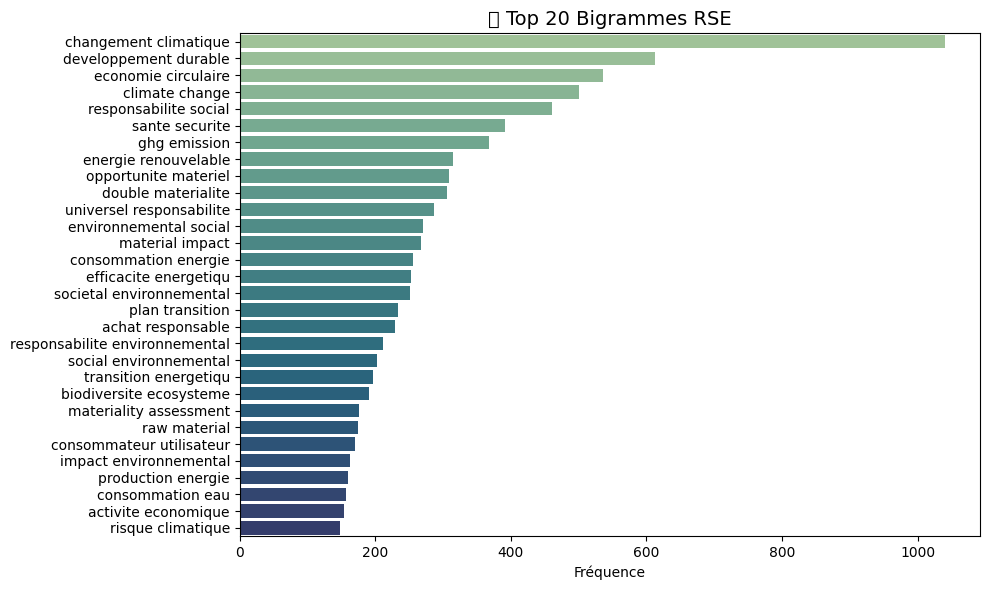

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_bi.sort_values("freq", ascending=False),
    y="ngram", x="freq", palette="crest"
)
plt.title("🟦 Top 20 Bigrammes RSE", fontsize=14)
plt.xlabel("Fréquence")
plt.ylabel("")
plt.tight_layout()
plt.show()


/tmp/ipython-input-433289324.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-433289324.py:9: UserWarning: Glyph 129002 (\N{LARGE PURPLE SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129002 (\N{LARGE PURPLE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


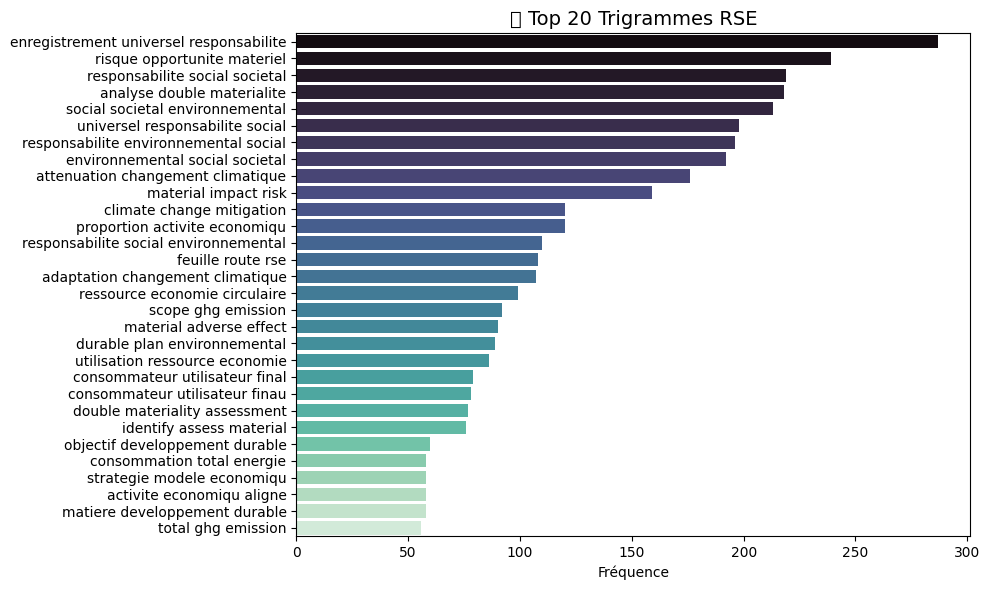

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_tri.sort_values("freq", ascending=False),
    y="ngram", x="freq", palette="mako"
)
plt.title("🟪 Top 20 Trigrammes RSE", fontsize=14)
plt.xlabel("Fréquence")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [41]:
print("Top 50 unigrammes RSE:")
display(top_uni)

Top 50 unigrammes RSE:


,ngram,freq
47,durable,2661
80,energie,2553
14,climatique,2233
95,environnemental,2194
190,transition,2066
49,eau,2022
125,material,2009
180,securite,1983
163,responsable,1883
172,sante,1828


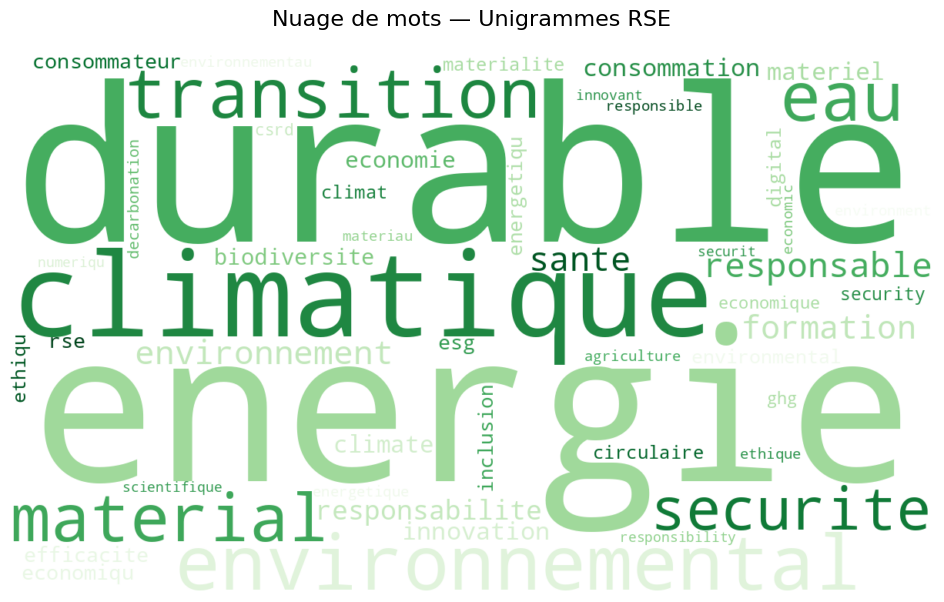

In [42]:
freqs_uni = dict(zip(top_uni["ngram"], top_uni["freq"]))

plt.figure(figsize=(12, 7))
wc_uni = WordCloud(
    width=1200, height=700,
    background_color="white",
    colormap="Greens",
    max_words=100,
    prefer_horizontal=0.9
).generate_from_frequencies(freqs_uni)

plt.imshow(wc_uni, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots — Unigrammes RSE", fontsize=16, pad=20)
plt.show()




---



In [45]:
donnees = pd.read_csv("/content/données(Feuil1).csv", sep=";", encoding="latin1")
donnees.columns


Index(['Nom', 'Sector (ICB)', 'Équivalent en français', 'Secteur connu',
       'Mots-clés', 'fréquence', 'Climat', 'inclusion ', 'finance durable ',
       'santé', 'Gouvernance ', 'environement ', 'Lien'],
      dtype='object')

In [48]:
from collections import Counter

def construire_unigrammes_par_entreprise(df_lem):
    lignes = []
    for nom, grp in df_lem.groupby("Nom"):
        # concatène tous les lemmes nettoyés de cette entreprise
        texte = " ".join(grp["lemmas_ng"].dropna().tolist())
        if not texte.strip():
            continue

        tokens = texte.split()
        compteur = Counter()

        for tok in tokens:
            if len(tok) <= 2:
                continue
            if not is_rse_token(tok):
                continue
            compteur[tok] += 1

        for terme, freq in compteur.items():
            lignes.append({
                "Entreprise": nom,
                "Unigramme": terme,
                "Frequence": int(freq)
            })

    return pd.DataFrame(lignes)

df_uni_emp = construire_unigrammes_par_entreprise(df_lem)
display(df_uni_emp.head())
print("Lignes totales df_uni_emp :", len(df_uni_emp))
print("Entreprises couvertes :", df_uni_emp['Entreprise'].nunique())


,Entreprise,Unigramme,Frequence
0,ACCOR,responsabilite,21
1,ACCOR,efficace,1
2,ACCOR,innovant,5
3,ACCOR,economiqu,19
4,ACCOR,durable,53


Lignes totales df_uni_emp : 2428
Entreprises couvertes : 40




---



In [49]:
tabela_resumo = resumo_top_unigrams(df_uni_emp, top_n=10)
display(tabela_resumo)

,Entreprise,Top_unigrammes_RSE
0,ACCOR,"durable (53), responsable (28), responsabilite..."
1,AIR LIQUIDE,"environnement (19), eau (15), formation (14), ..."
2,AIRBUS,"material (446), climate (321), environmental (..."
3,ARCELORMITTAL SA,"eau (2), biodiversite (1)"
4,AXA,"climatique (53), sante (40), inclusion (29), t..."
5,BNP PARIBAS ACT.A,"transition (97), durable (89), economie (66), ..."
6,BOUYGUES,"energie (73), responsable (38), durable (38), ..."
7,BUREAU VERITAS,"transition (27), esg (17), economy (13), respo..."
8,CAPGEMINI,"innovation (96), durable (54), digital (39), f..."
9,CARREFOUR,"consommation (283), consommateur (264), respon..."


In [50]:
# garder uniquement les colonnes pertinentes
donnees = donnees[["Nom", "Sector (ICB)", "Secteur connu"]]
donnees.columns = ["Entreprise", "Sector_ICB", "Secteur_connu"]

# fusionner avec les unigrammes
df_uni_sec = df_uni_emp.merge(donnees, on="Entreprise", how="left")

print(f"Lignes totales : {len(df_uni_sec)}")
display(df_uni_sec.head())


Lignes totales : 2428


,Entreprise,Unigramme,Frequence,Sector_ICB,Secteur_connu
0,ACCOR,responsabilite,21,Consumer Discretionary,Hôtellerie / Tourisme
1,ACCOR,efficace,1,Consumer Discretionary,Hôtellerie / Tourisme
2,ACCOR,innovant,5,Consumer Discretionary,Hôtellerie / Tourisme
3,ACCOR,economiqu,19,Consumer Discretionary,Hôtellerie / Tourisme
4,ACCOR,durable,53,Consumer Discretionary,Hôtellerie / Tourisme


In [51]:
TOP_N = 5  # moins de colonnes pour une meilleure lisibilité

linhas = []
for emp, grp in df_uni_emp.groupby("Entreprise"):
    g = grp.sort_values("Frequence", ascending=False).head(TOP_N)
    row = {"Entreprise": emp}
    for i, (w, f) in enumerate(zip(g["Unigramme"], g["Frequence"]), start=1):
        row[f"term_{i}"] = w
        row[f"freq_{i}"] = int(f)
    linhas.append(row)

tabela_wide = pd.DataFrame(linhas).sort_values("Entreprise")
display(tabela_wide)


,Entreprise,term_1,freq_1,term_2,freq_2,term_3,freq_3,term_4,freq_4,term_5,freq_5
0,ACCOR,durable,53,responsable,28,responsabilite,21.0,economiqu,19.0,innovation,19.0
1,AIR LIQUIDE,environnement,19,eau,15,formation,14.0,rse,14.0,securite,11.0
2,AIRBUS,material,446,climate,321,environmental,241.0,security,237.0,environment,122.0
3,ARCELORMITTAL SA,eau,2,biodiversite,1,NaN,NaN,NaN,NaN,NaN,NaN
4,AXA,climatique,53,sante,40,inclusion,29.0,transition,21.0,environnement,18.0
5,BNP PARIBAS ACT.A,transition,97,durable,89,economie,66.0,biodiversite,36.0,responsable,35.0
6,BOUYGUES,energie,73,responsable,38,durable,38.0,climatique,37.0,ethiqu,35.0
7,BUREAU VERITAS,transition,27,esg,17,economy,13.0,responsible,12.0,climate,12.0
8,CAPGEMINI,innovation,96,durable,54,digital,39.0,formation,33.0,energie,31.0
9,CARREFOUR,consommation,283,consommateur,264,responsable,264.0,transition,258.0,climatique,244.0


In [52]:
TOP_N = 10  # top 10 mots par secteur

def top_terms_by_sector(df, sector_col="Secteur_connu", n=TOP_N):
    lignes = []
    for sec, grp in df.groupby(sector_col):
        if pd.isna(sec):
            continue
        top = (grp.groupby("Unigramme")["Frequence"]
                  .sum()
                  .sort_values(ascending=False)
                  .head(n))
        lignes.append({
            "Secteur": sec,
            "Top_termes_RSE": ", ".join([f"{w} ({int(f)})" for w, f in top.items()])
        })
    return pd.DataFrame(lignes).sort_values("Secteur")

df_top_sec = top_terms_by_sector(df_uni_sec)
display(df_top_sec)


,Secteur,Top_termes_RSE
0,Agroalimentaire,"eau (591), durable (458), environnemental (380..."
1,Assurance,"climatique (53), sante (40), inclusion (29), t..."
2,Automobile,"material (531), environmental (157), security ..."
3,Aéronautique / Défense,"durable (47), innovation (47), securite (34), ..."
4,Banque,"climatique (323), durable (288), responsable (..."
5,Biotechnologies / Analyses médicales,"materiel (14), securite (3), consommation (3),..."
6,Centres commerciaux / Foncière,"security (67), material (57), responsibility (..."
7,Certification / Contrôle qualité,"transition (27), esg (17), economy (13), clima..."
8,Conseil / Services informatiques,"innovation (96), durable (54), digital (39), f..."
9,Construction / Concessions / Infrastructures,"economic (1), esg (1)"


In [53]:
output_path = "/content/top_termes_RSE_par_secteur.csv"

# --- enregistrer en CSV ---
df_top_sec.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ Fichier exporté : {output_path}")

✅ Fichier exporté : /content/top_termes_RSE_par_secteur.csv


In [54]:
# --- enregistrer en CSV ---
output_path = "/content/top_unigrammes_RSE_par_entreprise.csv"
tabela_wide.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ Fichier exporté: {output_path}")

✅ Fichier exporté: /content/top_unigrammes_RSE_par_entreprise.csv
